<a href="https://colab.research.google.com/github/MichaelJP-DS/Flight-Arrival-Classification-Models/blob/main/Flight_Arrival_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Arrival Classification Models

Working with different models to predict arrival times of flights from 2015

## Arrival Classes

1. More than 10 minutes Late
2. Less than 10 Minutes Late/On Time
3. Early


# Project Flow

Select Data Set

* Read in Data Set
* Set up wrangle function for cleaning and normalization
* Use Scikit-Learn to split data for training and validation
* Establish a Baseline
* Set up Models
* Test Accuracy
* Utilize Hyperparameter Tuning
* Use different analysis tools and visualizations to analyse results


# Baseline

* Select most predictable outcome using Value Counts Method


# Considerations

* Data Leakage


* Model Uses


* Other Uses?

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# Import Statements

# Libraries
import pandas as pd
import numpy as np

# Data Processing
from sklearn.preprocessing import minmax_scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# ML Boosted Model
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Neural Network/ML
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from keras.layers import Dropout

# MLP NN
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Tuning
from sklearn.model_selection import RandomizedSearchCV

# Viz & Analysis
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report


#TensorBoard
%load_ext tensorboard

In [2]:
df_flights = pd.read_csv('/content/drive/MyDrive/Classification Data/flights.csv', low_memory=False)

In [10]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Wrangle Function for NN w/ data normalization

In [3]:
def wrangle_neuralN(df):

  # Eliminate columns that may result in data leakage
  df = df.drop(columns= ['WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'ARRIVAL_TIME', 'YEAR', 'DAY'])

  # Drop rows when flight was cancelled but keep data when flight was not
  df = df.drop(df[df.CANCELLED == 1].index)

  df = df.drop(df[df.DIVERTED == 1].index)

  # Now drop cancelled column the resulting rows where not impacted by cancelled flight
  df = df.drop(columns= ['CANCELLED', 'CANCELLATION_REASON'])

  # Drop rows related to reason for departure delay & high null value count.
  df = df.drop(columns= ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIRLINE_DELAY','DIVERTED', 'DEPARTURE_DELAY'])

  # Drop High Cardinality Column
  df = df.drop(columns= ['TAIL_NUMBER', 'FLIGHT_NUMBER'])

  # Label encode Airline, Origin Airport and Destination Airport
  enc = preprocessing.LabelEncoder()
  df['AIRLINE'] = enc.fit_transform(df['AIRLINE'])
  df['ORIGIN_AIRPORT'] = enc.fit_transform(df['ORIGIN_AIRPORT'])
  df['DESTINATION_AIRPORT'] = enc.fit_transform(df['DESTINATION_AIRPORT'])

  # Impute limited null values with column mean
  df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].fillna(4)
  df['TAXI_IN'] = df['TAXI_IN'].fillna(7.4)  

  # Set up target column in classes
  df.loc[df['ARRIVAL_DELAY'] <= -10.0, 'ARRIVAL' ] = 0
  df.loc[(df['ARRIVAL_DELAY'] > -10.0) & (df['ARRIVAL_DELAY'] <= 0.0), 'ARRIVAL'] = 1
  df.loc[(df['ARRIVAL_DELAY'] > 0), 'ARRIVAL'] = 2
 
  # Convert arrival to Integer for NN
  df['ARRIVAL'] = df['ARRIVAL'].astype(int)

  # Drop modified column
  df = df.drop(columns='ARRIVAL_DELAY')

  # Normalize data for processing

  df['MONTH'] = minmax_scale(df['MONTH'])      
  df['DAY_OF_WEEK'] = minmax_scale(df['DAY_OF_WEEK'])
  df['AIRLINE'] = minmax_scale(df['AIRLINE'])
  df['ORIGIN_AIRPORT'] = minmax_scale(df['ORIGIN_AIRPORT'])
  df['DESTINATION_AIRPORT'] = minmax_scale(df['DESTINATION_AIRPORT'])
  df['SCHEDULED_DEPARTURE'] = minmax_scale(df['SCHEDULED_DEPARTURE'])
  df['DEPARTURE_TIME'] = minmax_scale(df['DEPARTURE_TIME'])
  #df['DEPARTURE_DELAY'] = minmax_scale(df['DEPARTURE_DELAY'])  
  df['TAXI_OUT'] = minmax_scale(df['TAXI_OUT'])
  df['SCHEDULED_TIME'] = minmax_scale(df['SCHEDULED_TIME'])      
  df['DISTANCE'] = minmax_scale(df['DISTANCE'])            
  df['TAXI_IN'] = minmax_scale(df['TAXI_IN'])                
  df['SCHEDULED_ARRIVAL'] = minmax_scale(df['SCHEDULED_ARRIVAL'])
  df['ARRIVAL'] = minmax_scale(df['ARRIVAL']) 

  df = df.iloc[0:1000000]               

  return df

## Wrangle Function for XGBClassifier non-normalized data

In [4]:
def wrangle_XGBClass(df):

  # Eliminate columns that may result in data leakage
  df = df.drop(columns= ['WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'ARRIVAL_TIME', 'YEAR', 'DAY'])

  # Drop rows when flight was cancelled but keep data when flight was not
  df = df.drop(df[df.CANCELLED == 1].index)

  df = df.drop(df[df.DIVERTED == 1].index)

  # Now drop cancelled column the resulting rows where not impacted by cancelled flight
  df = df.drop(columns= ['CANCELLED', 'CANCELLATION_REASON'])

  # Drop rows related to reason for departure delay & high null value count.
  df = df.drop(columns= ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIRLINE_DELAY', 'DIVERTED','DEPARTURE_DELAY'])

  # Drop High Cardinality Column
  df = df.drop(columns= ['TAIL_NUMBER', 'FLIGHT_NUMBER'])

  # Label encode Airline, Origin Airport and Destination Airport
  enc = preprocessing.LabelEncoder()
  df['AIRLINE'] = enc.fit_transform(df['AIRLINE'])
  df['ORIGIN_AIRPORT'] = enc.fit_transform(df['ORIGIN_AIRPORT'])
  df['DESTINATION_AIRPORT'] = enc.fit_transform(df['DESTINATION_AIRPORT'])

  # Impute limited null values with column mean
  df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].fillna(4)
  df['TAXI_IN'] = df['TAXI_IN'].fillna(7.4)  

  # Set up target column in classes
  df.loc[df['ARRIVAL_DELAY'] <= -10.0, 'ARRIVAL' ] = 0
  df.loc[(df['ARRIVAL_DELAY'] > -10.0) & (df['ARRIVAL_DELAY'] <= 0.0), 'ARRIVAL'] = 1
  df.loc[(df['ARRIVAL_DELAY'] > 0), 'ARRIVAL'] = 2

  
  # Convert arrival to Integer for NN
  df['ARRIVAL'] = df['ARRIVAL'].astype(int)

  # Drop modified column
  df = df.drop(columns='ARRIVAL_DELAY')

  df = df.iloc[0:1000000]    

  # Eliminate Features Based on Importance Results
  df = df.drop(columns = ['SCHEDULED_ARRIVAL'])           

  return df

## Run dataframe wrangle function

In [5]:
df_Neural_Net = wrangle_neuralN(df_flights)

In [6]:
df_Classifier = wrangle_XGBClass(df_flights)

## Quick Check for Null Values

In [12]:
df_Neural_Net.isnull().sum()

MONTH                  0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
SCHEDULED_TIME         0
DISTANCE               0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL                0
dtype: int64

In [13]:
df_Classifier.isnull().sum()

MONTH                  0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
SCHEDULED_TIME         0
DISTANCE               0
TAXI_IN                0
ARRIVAL                0
dtype: int64

## Train, Test, Split NN

In [7]:
y = df_Neural_Net['ARRIVAL']

X = df_Neural_Net.drop(columns='ARRIVAL')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train Test Split Classifier

In [9]:
y_C = df_Classifier['ARRIVAL']

X_C = df_Classifier.drop(columns='ARRIVAL')

In [10]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2)

## Model Baseline

In [11]:
BaseLine = y_train.value_counts(normalize=True).max()

print('Simple Baseline', BaseLine)

Simple Baseline 0.4225425


## Gradient Boosting Classifier

In [12]:
gbc_model = make_pipeline(
    XGBClassifier(n_estimators=5)
)

gbc_model.fit(X_train_C, y_train_C)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(n_estimators=5, objective='multi:softprob'))])

## Build Fully Connected Neural Network using Keras
 * Relu Activation Function
 * Softmax for Output
 * Multiclass Crossentropy Loss Function
 * Dropout and Early Stopping...model isn't overfitting though.
    * Possibly has to do with data being input...continue to work on cleaning

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = Sequential()
model.add(Dense(100, input_dim=12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          workers=-1, 
          epochs=2, 
          batch_size=16, 
          verbose=1,
          shuffle=True,
          callbacks=[callback])

## Sample MLPClassifier SciKit Learn's Neural Net

In [13]:
model_mlpc = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(5,),activation='logistic', max_iter=10000,learning_rate='invscaling',random_state=0)
)

model_mlpc.fit(X_train_C,y_train_C)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=(5,),
                               learning_rate='invscaling', max_iter=10000,
                               random_state=0))])

## Check Scores

* XGBoost

In [14]:
print('Test Score', accuracy_score(y_train_C, gbc_model.predict(X_train_C)))
print('Val Score', accuracy_score(y_test_C, gbc_model.predict(X_test_C)))

Test Score 0.503885
Val Score 0.504855


* MLPClassifier Score

In [15]:
print('Test Score', accuracy_score(y_train_C, model_mlpc.predict(X_train_C)))
print('Val Score', accuracy_score(y_test_C, model_mlpc.predict(X_test_C)))

Test Score 0.70167375
Val Score 0.70259


# Hyperparameter Tuning
* XGBoost Classifier
* MLP Classifier
* Keras/Tensorflow

In [ ]:
clf = make_pipeline(
    XGBClassifier(),
)

xgbc_param_grid = {
                 'xgbclassifier__max_depth': range(0, 40, 10),
                 'xgbclassifier__n_estimators': range(25, 100, 25),
                 'xgbclassifier__booster': ['gbtree', 'gblinear', 'dart'],
                 }

model_xgbc = RandomizedSearchCV(
    clf,
    param_distributions = xgbc_param_grid,
    n_jobs=-1,
    cv=3,
    n_iter=3,
)

model_xgbc.fit(X_train_C, y_train_C)

In [ ]:
clf = make_pipeline(
    StandardScaler(),
    MLPClassifier(),
)

mlpc_param_grid = {
                 'mlpclassifier__solver': ['sgd', 'adam'],
                 'mlpclassifier__learning_rate_init': range(0.001, 0.01, .005)
                 'mlpclassifier__early_stopping': [True, False],
                 }

model_mlpc = RandomizedSearchCV(
    clf,
    param_distributions = mlpc_param_grid,
    n_jobs=-1,
    cv=3,
    n_iter=5,
)

model_mlpc.fit(X_train_C, y_train_C)

In [ ]:
## Setting up Keras HT

hyper_parameters = {
    "reg_penalty": [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    "Lp_reg": [l2],
    "epochs": [1], 
}

grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-1, 
                    verbose=1, 
                    cv=2)

grid_result = grid.fit(X_train, y_train)

### GBC Feature Importances

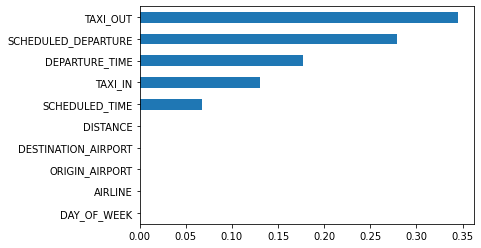

In [16]:
importances = gbc_model.named_steps.xgbclassifier.feature_importances_
features = X_train_C.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

### GBC Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


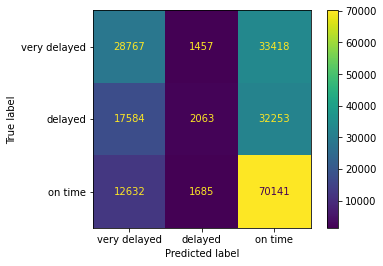

In [17]:
GBC = plot_confusion_matrix(
    gbc_model,
    X_test_C,
    y_test_C,
    values_format = '.0f',
    display_labels = ['very delayed', 'delayed', 'on time']

);

In [18]:
print(classification_report(y_test_C,
                            gbc_model.predict(X_test_C),
                            target_names = ['very delayed', 'delayed', 'on time']))

              precision    recall  f1-score   support

very delayed       0.49      0.45      0.47     63642
     delayed       0.40      0.04      0.07     51900
     on time       0.52      0.83      0.64     84458

    accuracy                           0.50    200000
   macro avg       0.47      0.44      0.39    200000
weighted avg       0.48      0.50      0.44    200000



## MLPClassifier Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


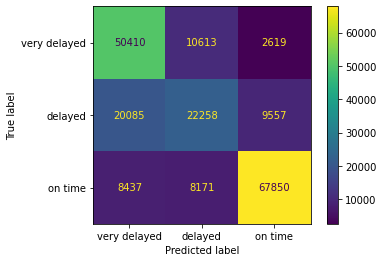

In [19]:
GBC = plot_confusion_matrix(
    model_mlpc,
    X_test_C,
    y_test_C,
    values_format = '.0f',
    display_labels = ['very delayed', 'delayed', 'on time']);

In [20]:
print(classification_report(y_test_C,
                            model_mlpc.predict(X_test_C),
                            target_names = ['very delayed', 'delayed', 'on time']))

              precision    recall  f1-score   support

very delayed       0.64      0.79      0.71     63642
     delayed       0.54      0.43      0.48     51900
     on time       0.85      0.80      0.83     84458

    accuracy                           0.70    200000
   macro avg       0.68      0.67      0.67    200000
weighted avg       0.70      0.70      0.70    200000



### Tensorboard Visualizations for Keras/Tensorflow